In [108]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
from sklearn.metrics import accuracy_score, confusion_matrix, cohen_kappa_score
import numpy as np

In [60]:
def plot_confusion_matrix(cf_matrix, save_path=None, pixel_level=True, kappa=None, acc=None, y_label='True', x_label='Pred'):
    """ Plots the confusion matrix

    Args:
        cf_matrix: the confusion matrix to plot
        save_path: location where to store the plot
        plot: whether to plot it of save it
        pixel_level: whether to include bg
        kappa: plot kappa as title

    Returns:
        none: saves the figure at the save path

    """

    labels = ['NDBE', 'IND', 'LGD', 'HGD']
    fmt = 'd'

    df_cm = pd.DataFrame(cf_matrix, index=labels, columns=labels)

    plt.figure(figsize=(15, 10))
    plt.rcParams.update({'font.size': 22})
    sns.heatmap(df_cm, annot=True, cmap="Blues", square=True, fmt=fmt)
    plt.gca().set_yticklabels(labels=labels, va='center')
    plt.gca().set_ylabel(y_label, labelpad=30)
    plt.gca().set_xlabel(x_label, labelpad=30)
    plt.title('$\kappa=${:.2f}, acc={:.2f}'.format(kappa, acc))
    plt.show()

In [ ]:
rbe_case_df = pd.read_csv('/data/archief/AMC-data/Barrett/labels/rbe_case_level.csv')
rbe_biopsy_df = pd.read_csv('/data/archief/AMC-data/Barrett/labels/rbe_biopsy_level.csv')

display(rbe_case_df)
display(rbe_biopsy_df)

plt.figure(figsize=(16, 8))
plt.subplot(121)
rbe_case_df.groupby('grade').size().plot(kind='pie', autopct='%.2f', colors=['red', 'yellow', 'cyan'])
plt.title('{} cases'.format(len(rbe_case_df)))
plt.ylabel('')
plt.subplot(122)
rbe_biopsy_df.groupby('grade').size().plot(kind='pie', autopct='%.2f', colors=['red', 'yellow', 'cyan'])
plt.title('{} biopsies'.format(len(rbe_biopsy_df)))
plt.ylabel('')
plt.show()

In [ ]:
dysplasia_cases = rbe_case_df.loc[(rbe_case_df['grade'] == 'LGD') | (rbe_case_df['grade'] == 'HGD')]['case']
#display(dysplasia_cases)
for l in list(dysplasia_cases):
    print(l)
dysplasia_cases.to_csv('/data/archief/AMC-data/Barrett/labels/dyplasia_cases_rbe_reader_study.csv', index=False)

In [ ]:
rbe_biopsy_df[['case', 'biopsy']] = rbe_biopsy_df['biopsy'].str.split('HE', expand=True)
rbe_biopsy_df['case'] = rbe_biopsy_df['case'].str[:-1]

rbe_biopsy_df.loc[rbe_biopsy_df['case'].isin(dysplasia_cases)]

## Code for generation of CSV's

In [2]:
overview_path = '/data/archief/AMC-data/Barrett/labels/rbe_overview.csv'
df = pd.read_csv(overview_path)
df.reset_index(inplace=True)
df_biopsy = df.rename(columns = {'index':'id', 'Diagnoses Barrett dataset ': 'grade'})
df_biopsy = df_biopsy[df_biopsy.grade != 'Problem']
df_biopsy['grade_num'] = df_biopsy['grade'].map({'NDBE': 1, 'LGD': 3, 'HGD': 4})
display(df_biopsy)
df_biopsy.to_csv('/data/archief/AMC-data/Barrett/labels/rbe_biopsy_level.csv', index=False)

,id,grade,grade_num
0,ASL01_3_HE-1,NDBE,1
1,ASL01_3_HE-2,LGD,3
2,ASL01_3_HE-3,LGD,3
3,ASL02_1_HE-1,NDBE,1
4,ASL02_1_HE-2,NDBE,1
...,...,...,...
794,ROCT38_XII-HE1-1,NDBE,1
795,ROCT38_XII-HE1-2,NDBE,1
796,ROCT39_V-HE1-1,HGD,4
797,ROCT39_VI-HE1-1,HGD,4


## Lets group them by slide

In [3]:
df_slide = df_biopsy
df_slide['slide'] = df_slide['id'].map(lambda x: str(x)[:-2])
df_slide['biopsy_nr'] = df_slide['id'].map(lambda x: str(x)[-1])
print(df_slide)

                   id grade  grade_num           slide biopsy_nr
0        ASL01_3_HE-1  NDBE          1      ASL01_3_HE         1
1        ASL01_3_HE-2   LGD          3      ASL01_3_HE         2
2        ASL01_3_HE-3   LGD          3      ASL01_3_HE         3
3        ASL02_1_HE-1  NDBE          1      ASL02_1_HE         1
4        ASL02_1_HE-2  NDBE          1      ASL02_1_HE         2
..                ...   ...        ...             ...       ...
794  ROCT38_XII-HE1-1  NDBE          1  ROCT38_XII-HE1         1
795  ROCT38_XII-HE1-2  NDBE          1  ROCT38_XII-HE1         2
796    ROCT39_V-HE1-1   HGD          4    ROCT39_V-HE1         1
797   ROCT39_VI-HE1-1   HGD          4   ROCT39_VI-HE1         1
798   ROCT51_VI-HE1-1   HGD          4   ROCT51_VI-HE1         1

[757 rows x 5 columns]


In [5]:
df_slide['max grade'] = df_slide.groupby('slide')['grade_num'].transform('max')
df_slide = df_slide.drop_duplicates(subset=['slide'])
df_slide = df_slide.drop_duplicates(subset=['slide'])[['slide', 'max grade']]
df_slide = df_slide.rename(columns={'max grade': 'grade_num'})
df_slide['grade'] = df_slide['grade_num'].map({1:'NDBE', 3: 'LGD', 4: 'HGD'})
display(df_slide)
df_slide.to_csv('/data/archief/AMC-data/Barrett/labels/rbe_slide_level.csv', index=False)

,slide,grade_num,grade
0,ASL01_3_HE,3,LGD
3,ASL02_1_HE,1,NDBE
7,ASL03_1_HE,3,LGD
10,ASL04_1_HE,1,NDBE
14,ASL05_1_HE,1,NDBE
...,...,...,...
793,ROCT38_XI-HE1,4,HGD
794,ROCT38_XII-HE1,1,NDBE
796,ROCT39_V-HE1,4,HGD
797,ROCT39_VI-HE1,4,HGD


### 55x55 Bolero

In [144]:
bolero_case_df = pd.read_excel('/data/archief/AMC-data/Barrett/labels/55x55 dx table BOLERO.xlsx', index_col=0, header=None).T.iloc[1:].sort_values(by=['casus nummers'])
#display(bolero_case_df)

In [145]:
# NDBE = 0
# IND  = 1
# LGD  = 2
# HGD  = 3
filtered_df = bolero_case_df[['casus nummers', 'AMC SM', 'University College Hosp MJ', 'University MC JO', 'Antonius Hosp KS', 'gold standard diagnosis']]
filtered_df = filtered_df.replace(1, 0)
filtered_df = filtered_df.replace(4, 1)
print(filtered_df['gold standard diagnosis'].value_counts())
display(filtered_df)

2    21
0    16
3    13
1     5
Name: gold standard diagnosis, dtype: int64


,casus nummers,AMC SM,University College Hosp MJ,University MC JO,Antonius Hosp KS,gold standard diagnosis
8,RB0001,3,2,3,3,3
9,RB0002,3,3,3,3,3
10,RB0003,0,0,0,1,0
11,RB0004,3,2,2,2,2
12,RB0005,2,2,1,3,2
13,RB0006,1,2,0,0,1
14,RB0007,2,2,1,3,2
15,RB0008,2,1,2,3,2
16,RB0009,3,3,3,3,3
17,RB0010,2,1,1,3,2


In [146]:
raters = list(filtered_df.columns[1:5])
print(raters)

['AMC SM', 'University College Hosp MJ', 'University MC JO', 'Antonius Hosp KS']


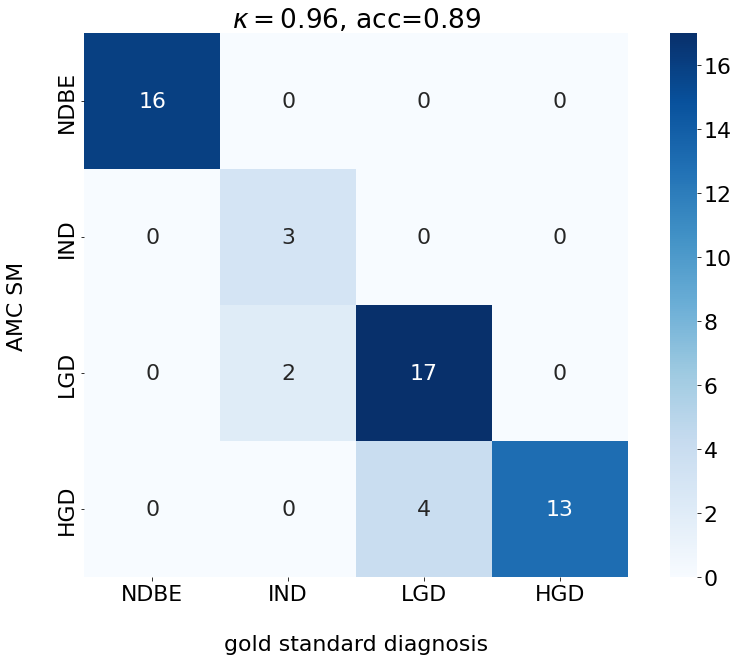

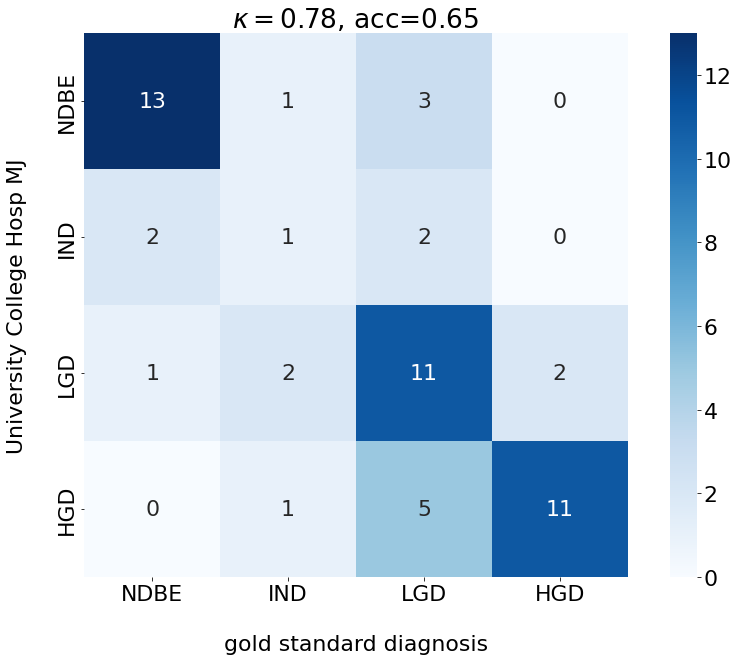

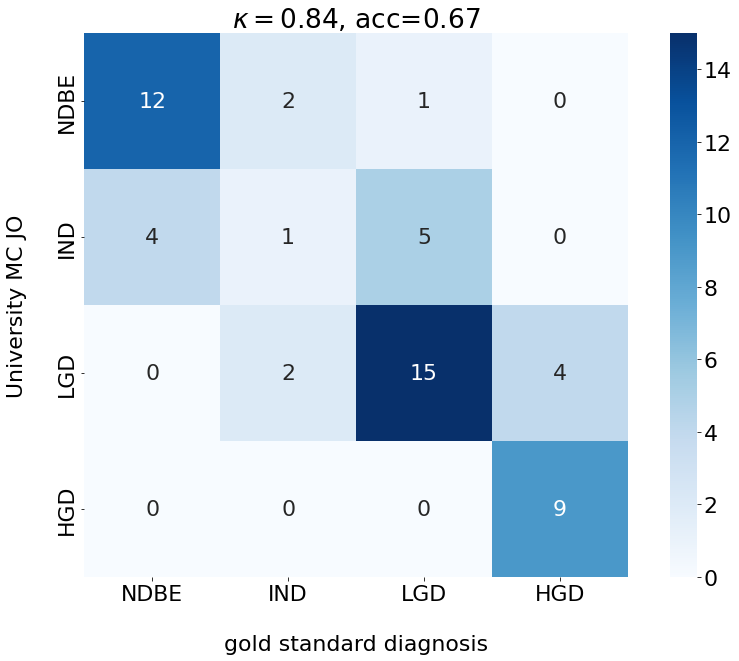

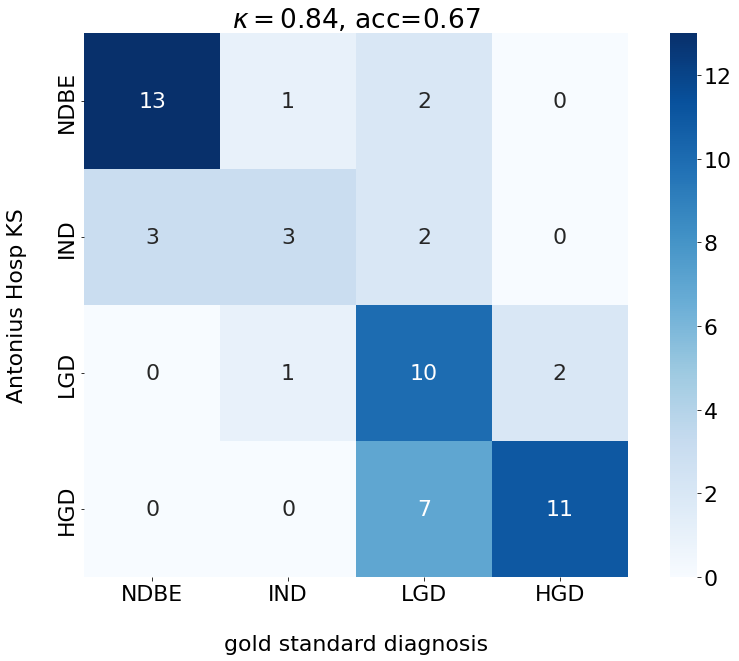

In [147]:
for rater in raters:
    y_label = rater
    x_label = 'gold standard diagnosis'
    y_true = filtered_df[y_label]
    y_pred = filtered_df[x_label]

    acc = accuracy_score(y_true, y_pred)
    kappa = cohen_kappa_score(y_true, y_pred, weights='quadratic')
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1, 2, 3])
    plot_confusion_matrix(cm, kappa=kappa, acc=acc, y_label=y_label, x_label=x_label)

In [148]:
for i, grade in enumerate(['NDBE', 'IND', 'LGD', 'HGD']):
    grade_df = filtered_df[filtered_df['gold standard diagnosis'] == i]
    agree_df = grade_df[(grade_df['AMC SM'] == i) &
                    (grade_df['University College Hosp MJ'] == i) &
                    (grade_df['University MC JO'] == i) &
                    (grade_df['Antonius Hosp KS'] == i)]
    print('Total agreement {}: {}/{}={:.2f}'.format(grade, len(agree_df), len(grade_df), len(agree_df) / len(grade_df)))
    # display(grade_df)

Total agreement NDBE: 8/16=0.50
Total agreement IND: 0/5=0.00
Total agreement LGD: 4/21=0.19
Total agreement HGD: 7/13=0.54


In [149]:
for i, grade in enumerate(['NDBE', 'IND', 'LGD', 'HGD']):
    accuracy_per_rater = []
    grade_df = filtered_df[filtered_df['gold standard diagnosis'] == i]
    
    for rater in raters:
        acc = accuracy_score(grade_df[rater], grade_df['gold standard diagnosis'])
        accuracy_per_rater.append(acc)
        
    print('{}: {:.2f}'.format(grade, np.mean(accuracy_per_rater)))

NDBE: 0.84
IND: 0.40
LGD: 0.63
HGD: 0.85


In [169]:
# pairwise kappa/accuracy
kappas = []
accs = []

for first_rater in raters:
    for second_rater in [rater for rater in raters if rater is not first_rater]:
        first_rater_grades = filtered_df[first_rater]
        second_rater_grades = filtered_df[second_rater]
        acc = accuracy_score(first_rater_grades, second_rater_grades)
        kappa = cohen_kappa_score(first_rater_grades, second_rater_grades, weights='quadratic')
        kappas.append(kappa)
        accs.append(acc)
        # cm = confusion_matrix(first_rater_grades, second_rater_grades, labels=[0, 1, 2, 3])
        # plot_confusion_matrix(cm, kappa=kappa, acc=acc, y_label=first_rater, x_label=second_rater)
 
# we got everything double now but is the same average..
print('Pair wise average kappa between raters: {:.2f}'.format(np.mean(kappas)))
print('Pair wise average accuracy between raters: {:.2f}'.format(np.mean(accs)))
print(len(kappas))

Pair wise average kappa between raters: 0.73
Pair wise average accuracy between raters: 0.58
12


In [165]:
# Fleiss kappa